# FLORDB: Retroactive Query Evaluation for Iterative AI/ML
### Rolando Garcia presenting for EPIC Retreat, Napa, 2023

repository: github.com/ucbrise/flor

In [ ]:
%pip install flordb

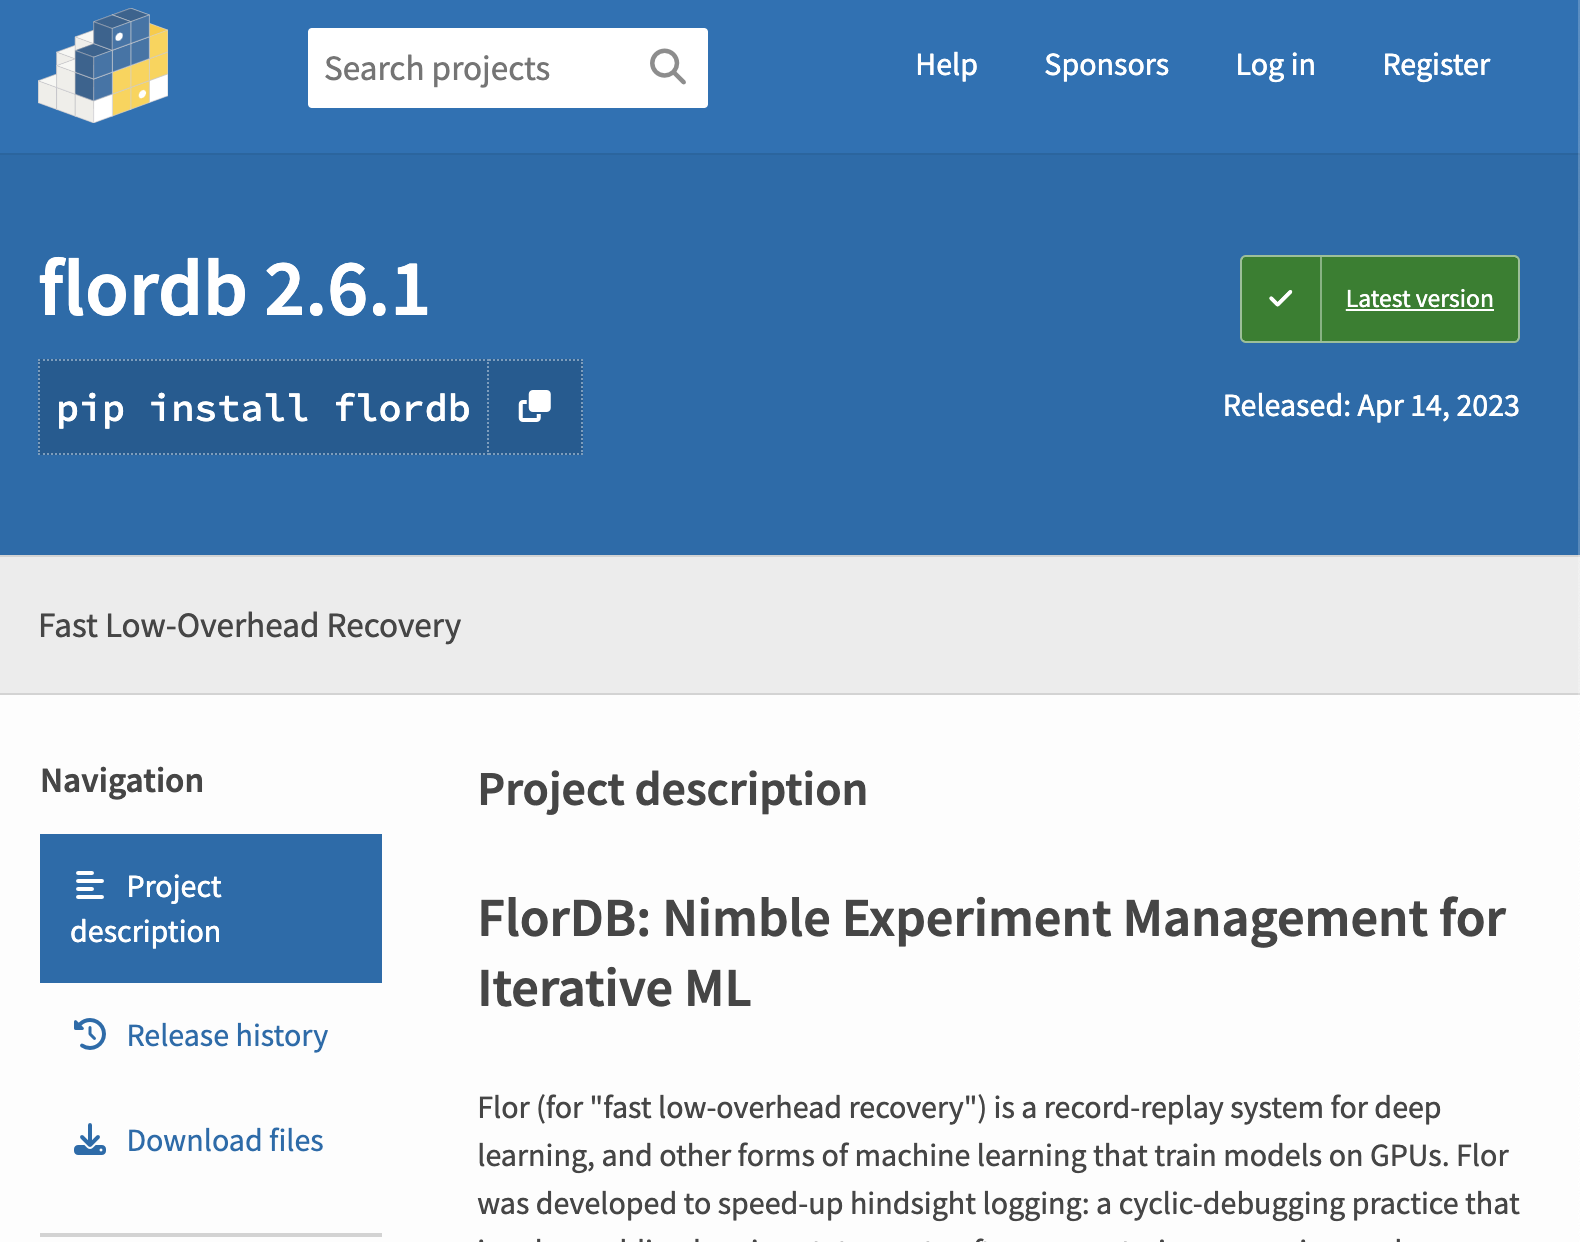

In [ ]:
import flor

In [ ]:
# Download ML Tutorials
!git clone https://github.com/ucbepic/ml_tutorial.git /content/ml_tutorial

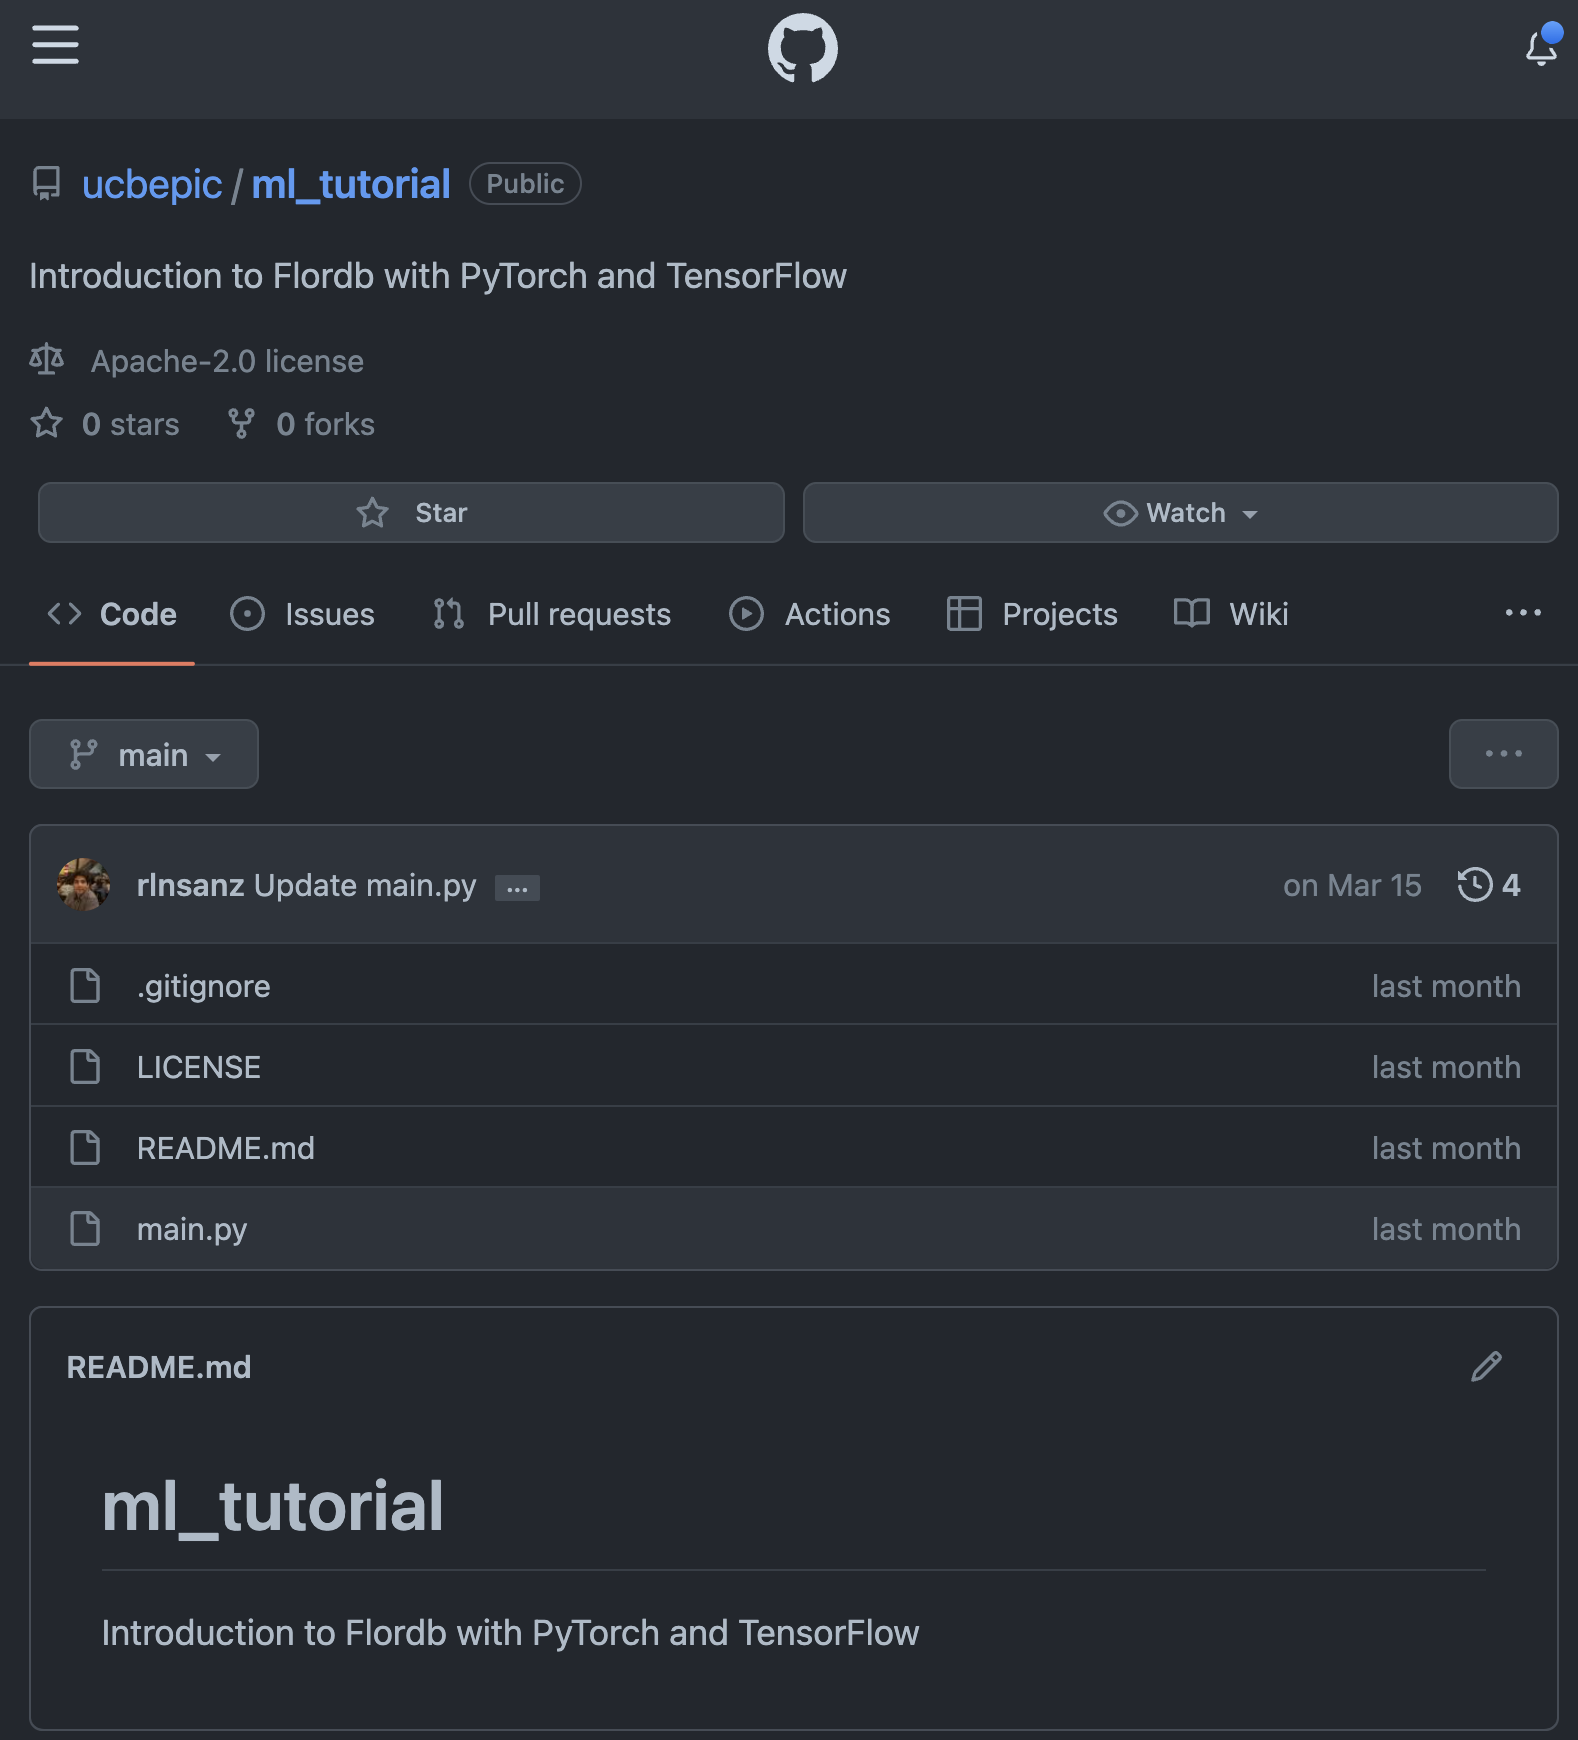

In [ ]:
import os
os.chdir('/content/ml_tutorial')

# Let's instrument `main.py` for Flor Record-Replay
* `Flor.checkpoints()`: Pass in the objects to checkpoint periodically
* `Flor.loop()`: Wrap iterators for (1) the main epoch loop and (2) the nested training loop


```python
...
Flor.checkpoints(model, optimizer)
for epoch in Flor.loop(range(num_epochs)):
    for i, (images, labels) in Flor.loop(enumerate(train_loader)):
      ...
```


In [ ]:
!code /content/ml_tutorial/main.py

Next, flor will:
* Write logs to `Git`
* Write checkpoints to `Shared Drive` 

And:
- Commit changes to `Git`

In [ ]:
!python main.py --flor EpicDemo

We want to create a **new branch** with a `flor.shadow` prefix (and switch into that branch) in which we give Flor permission to commit to `Git` automatically on every run.

In [ ]:
!git checkout -b flor.shadow

Next, we read the log records written by past runs into a Pivoted Dataframe

In [ ]:
from flor import log_records, full_pivot
pvt = full_pivot(log_records())
pvt

And we display the logged confusion matrix

In [ ]:
from IPython.display import display
from IPython.core.display import Image
from pathlib import PurePath

pvt = full_pivot(log_records())
for projid,runid,tstamp,vid,cf_matrix in pvt[
    list(flor.DATA_PREP) + ['cf_matrix']].drop_duplicates().values:
  if not isinstance(cf_matrix, float):
    p = PurePath(cf_matrix)
    display(Image(p))

# Loading log records from someone else's experimentation
First, we look at the **remote branches** available in the `ml_tutorial` repository.

In [ ]:
!git branch -r

We switch into a branch we want to explore further.

In [ ]:
!git checkout flor.shadow.compressed

And, like before, we read the log records written by past runs into a Pivoted Dataframe, but this time from the branch `flor.shadow.compressed`

In [ ]:
from flor import log_records, full_pivot
pvt = full_pivot(log_records())
pvt[list(flor.DATA_PREP) 
+ ['cf_matrix', 'hidden_size', 
   'lr', 'batch_size', 'accuracy']].drop_duplicates()

# The Pivoted Dataframe is missing data
* My colleague did not log `cf_matrix` or `accuracy`
* We did not log the `hidden_size`, `lr`, `batch_size`

First, we preview the available confusion matrices:

In [ ]:
from IPython.display import display
from IPython.core.display import Image
from pathlib import PurePath

pvt = full_pivot(log_records())
for projid,runid,tstamp,vid,cf_matrix,accuracy in pvt[
    list(flor.DATA_PREP) + ['cf_matrix', 'accuracy']].drop_duplicates().values:
  if not isinstance(cf_matrix, float):
    p = PurePath(cf_matrix)
    print((runid, str(tstamp), accuracy))
    display(Image(p))

Wouldn't it be nice if we could send our logging statements back in time, so that we could better compare our models using the same evaluation logic and metrics?

FlorDB Replay will:
1. Select the versions from the pivoted view that satisfy the `where_clause`
1. Estimate the time it will take to replay the selected versions
1. Check out the versions one-by-one, patching the code to include additional logging statements indicated in `apply_vars`
1. Replay the patched historical version using memoization and parallelism as possible to retrieve logged data

In [ ]:
flor.replay(apply_vars=['cf_matrix'], where_clause='cf_matrix.isna() and hidden_size.astype("float") < 250', path='main.py')